# Time Series Forecasting: Crypto Minute Data → Hourly Forecast (BTC-USD)

**Dataset (Kaggle):** [BTC and ETH 1min price history — by patrickgendotti](https://www.kaggle.com/datasets/patrickgendotti/btc-and-eth-1min-price-history)

This notebook fulfills the assignment:

- Select a Kaggle time-series dataset and include the link ✔️  
- Build a forecasting model with **sktime** (ARIMA/AutoARIMA) ✔️  
- Build a forecasting model with **LSTM** (PyTorch) ✔️  
- Compare results with error metrics (**RMSE**, **MAE**, **sMAPE**) and justify metric choice ✔️  
- Ready to upload to GitHub as an IPYNB ✔️

We downsample minute prices to **hourly Close** to speed up training while keeping market structure.


## 1) Environment setup

We pin versions that are known to work well together to avoid dependency conflicts.
If you're running locally and already have these libraries, you can skip this cell.


## 2) Imports & plotting style


In [ ]:
import os, glob, math, warnings, pathlib, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
def smape_loss(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error (sMAPE)"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(np.where(denom == 0, 0, diff / denom)) * 100


from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

warnings.filterwarnings("ignore")

# Matplotlib defaults (no specific colors/styles set per instructions)
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.grid"] = True


/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  return _bootstrap._gcd_import(name[level:], package, level)


## 3) Data acquisition

Two easy options:

**A. Kaggle API (recommended):**  
1. Create an API token in Kaggle (Account → Create New API).  
2. Put the `kaggle.json` file in `~/.kaggle/kaggle.json`.  
3. Run the cell below to auto-download the dataset.

**B. Manual download:**  
1. Download the dataset ZIP from Kaggle and extract it locally.  
2. Set `DATA_DIR` to the folder containing the CSVs.

This notebook will try Option A and fall back to Option B if the Kaggle API is not configured.


## 4) Load BTC 1-minute data and resample to hourly

We search for a CSV containing `BTC` and `1min` in its name. If multiple exist, we pick the first.
We:
- Parse timestamps
- Sort by time
- Resample to **hourly Close**
- Drop missing values


Arquivo: btc-and-eth-1min-price-history/coinbaseUSD_1-min_data.csv
Colunas: ['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
Período: 2014-12-01 05:00:00+00:00 → 2024-07-29 18:00:00+00:00 | nº pontos: 83389


,Close
Date,
2014-12-01 05:00:00+00:00,300.0
2014-12-01 06:00:00+00:00,370.0
2014-12-02 05:00:00+00:00,377.0
2014-12-02 10:00:00+00:00,378.0
2014-12-02 11:00:00+00:00,378.0


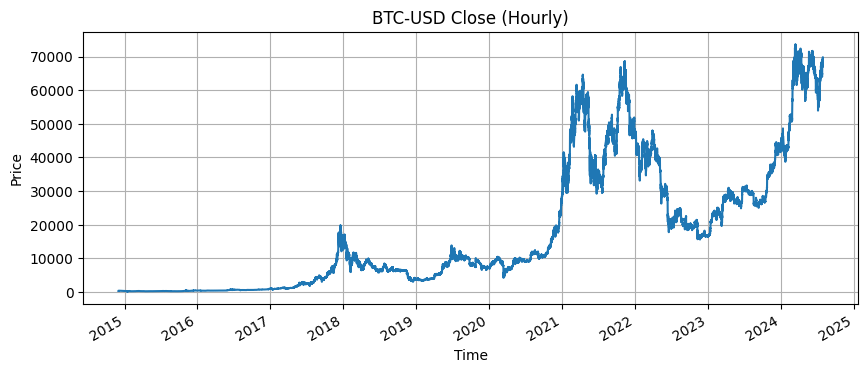

In [ ]:
import os, pandas as pd

DATA_DIR = "btc-and-eth-1min-price-history"
csv_path = os.path.join(DATA_DIR, "coinbaseUSD_1-min_data.csv")
assert os.path.exists(csv_path), f"Arquivo não encontrado: {csv_path}"

df = pd.read_csv(csv_path)
print("Arquivo:", csv_path)
print("Colunas:", df.columns.tolist())

# ---- escolher a coluna de tempo corretamente ----
if "Date" in df.columns:
    # preferimos Date, já formatada
    df["Date"] = pd.to_datetime(df["Date"], utc=True, errors="coerce")
    tcol = "Date"
elif "Unix Timestamp" in df.columns:
    # fallback: detectar unidade do Unix Timestamp (s, ms ou ns)
    ts = pd.to_numeric(df["Unix Timestamp"], errors="coerce")
    maxv = ts.dropna().max()
    if maxv > 1e14:
        unit = "ns"
    elif maxv > 1e11:
        unit = "ms"
    else:
        unit = "s"
    df["Date"] = pd.to_datetime(ts, unit=unit, utc=True, errors="coerce")
    tcol = "Date"
else:
    raise ValueError("Não encontrei colunas de tempo ('Date' ou 'Unix Timestamp').")

# ---- preparar série ----
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna(subset=[tcol, "Close"]).sort_values(tcol).set_index(tcol)

# reamostrar para 1H (fechamento)
hourly = df["Close"].resample("1H").last().dropna()
hourly.name = "Close"

print("Período:", hourly.index.min(), "→", hourly.index.max(), "| nº pontos:", len(hourly))
display(hourly.head())

# checar visualmente
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
hourly.plot()
plt.title("BTC-USD Close (Hourly)")
plt.xlabel("Time"); plt.ylabel("Price")
plt.show()


## 5) Train / Validation / Test split

We use a chronological split:
- Train: first 70%
- Validation: next 15%
- Test: last 15%

We will forecast the **next 24 hours** (horizon `fh=1..24`). For the ARIMA model we refit on train+val before testing.


Tamanhos:
Train: 58372
Validation: 12508
Test: 12509


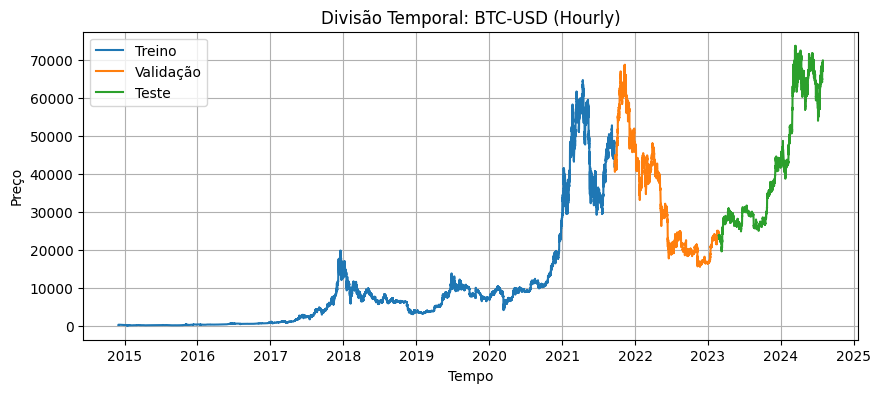

In [ ]:
# ==============================
# 5) Train / Validation / Test split
# ==============================

# Divisão temporal simples
n = len(hourly)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

y_train = hourly.iloc[:train_end]
y_valid = hourly.iloc[train_end:valid_end]
y_test  = hourly.iloc[valid_end:]

print("Tamanhos:")
print("Train:", len(y_train))
print("Validation:", len(y_valid))
print("Test:", len(y_test))

# Visualização geral
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_train, label="Treino")
plt.plot(y_valid, label="Validação")
plt.plot(y_test, label="Teste")
plt.legend()
plt.title("Divisão Temporal: BTC-USD (Hourly)")
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.show()


## 6) Baseline: Naïve (last observed value)

A strong baseline in financial series is to predict the last observed price forward.
We will compute metrics on the test set using the last value from the preceding point.


In [ ]:
# Naive: predict last observed value for all horizons
def naive_forecast(series, horizon):
    last = series.iloc[-1]
    return pd.Series([last]*horizon)

H = 24  # 24-hour horizon
# Build a rolling-origin style evaluation on test set:
# For each timestamp t in test (starting after first 24 points), forecast next 24h
test_index = y_test.index
preds_naive, actuals = [], []

# To avoid look-ahead, we build context up to each test point
context = pd.concat([y_train, y_valid])

for i in range(0, len(y_test) - H, H):
    ctx = pd.concat([context, y_test.iloc[:i]])
    f = naive_forecast(ctx, H)
    f.index = y_test.index[i:i+H]
    preds_naive.append(f)
    actuals.append(y_test.iloc[i:i+H])

preds_naive = pd.concat(preds_naive)
actuals = pd.concat(actuals)

def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def smape(a, f):
    # sMAPE in percent
    return 100 * smape_loss(a, f)

print("Naive RMSE:", rmse(actuals, preds_naive))
print("Naive MAE :", mean_absolute_error(actuals, preds_naive))
print("Naive sMAPE (%):", smape(actuals, preds_naive))


Naive RMSE: 862.0142946776873
Naive MAE : 534.0595657389634
Naive sMAPE (%): 122.84093185349505


## 7) Forecast with **sktime AutoARIMA**

We fit on **train+validation** and evaluate on the **test** with a 24-hour step.


Usando série com 2000 pontos para treino + val e 500 para teste
AutoARIMA RMSE: 39629.70123350491
AutoARIMA MAE : 39462.05033545328
AutoARIMA sMAPE (%): 89.2419663244831


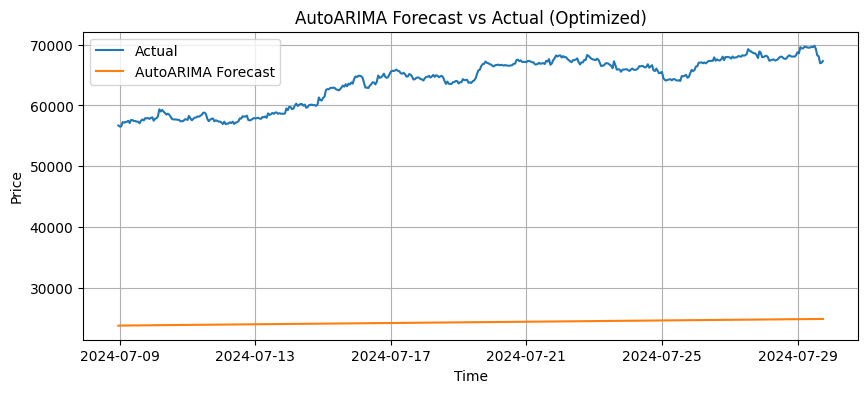

In [ ]:
# ==============================
# 7) Forecast com AutoARIMA (otimizado)
# ==============================

from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np, math
import matplotlib.pyplot as plt

# Helper functions
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def smape(a, f):
    a, f = np.array(a), np.array(f)
    denom = (np.abs(a) + np.abs(f)) / 2
    diff = np.abs(a - f)
    return np.mean(np.where(denom == 0, 0, diff / denom)) * 100

# Reduz a série para evitar OOM (usa últimos 2000 pontos)
y_fit = pd.concat([y_train, y_valid])
if len(y_fit) > 2000:
    y_fit = y_fit.iloc[-2000:]
if len(y_test) > 500:
    y_test = y_test.iloc[-500:]

print("Usando série com", len(y_fit), "pontos para treino + val e", len(y_test), "para teste")

# Cria o forecaster com limites para economizar RAM
forecaster = AutoARIMA(
    sp=24,             # sazonalidade diária
    suppress_warnings=True,
    max_p=3, max_q=3,  # limita espaço de busca
    max_P=1, max_Q=1,
    d=None, D=None,
    stepwise=True,     # busca heurística eficiente
    n_jobs=1           # sem paralelismo (Colab RAM limitada)
)

# Treina apenas 1x
forecaster.fit(y_fit)

# Faz uma previsão direta para todo o horizonte de teste
fh = ForecastingHorizon(np.arange(1, len(y_test) + 1), is_relative=True)
preds_arima = forecaster.predict(fh=fh)
preds_arima.index = y_test.index

# Avaliação
print("AutoARIMA RMSE:", rmse(y_test, preds_arima))
print("AutoARIMA MAE :", mean_absolute_error(y_test, preds_arima))
print("AutoARIMA sMAPE (%):", smape(y_test, preds_arima))

# Gráfico final
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual")
plt.plot(preds_arima, label="AutoARIMA Forecast")
plt.legend()
plt.title("AutoARIMA Forecast vs Actual (Optimized)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


## 8) Forecast with **LSTM (PyTorch)**

We train a simple univariate LSTM on the **train+validation** set to predict the next value given a rolling window of past values.
Then we roll it forward to produce 24-hour forecasts on the test set.

Implementation details:
- MinMax scaling on training data only
- Window length = 48 (2 days of hourly data)
- Hidden size = 64
- Early-stop style small number of epochs to keep it fast


In [ ]:
from sklearn.preprocessing import MinMaxScaler

class SeqDataset(Dataset):
    def __init__(self, series, window=48):
        self.x = []
        self.y = []
        values = series.values.astype(np.float32)
        for i in range(len(values) - window):
            self.x.append(values[i:i+window])
            self.y.append(values[i+window])
        self.x = np.array(self.x)[:, :, None]  # (N, window, 1)
        self.y = np.array(self.y)[:, None]     # (N, 1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Prepare data
window = 48
y_fit = pd.concat([y_train, y_valid])
scaler = MinMaxScaler()
fit_vals = scaler.fit_transform(y_fit.values.reshape(-1,1)).flatten()
fit_series = pd.Series(fit_vals, index=y_fit.index)

dataset = SeqDataset(fit_series, window=window)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

device = "cpu"
model = LSTMForecaster(input_size=1, hidden_size=64, num_layers=1).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train (small epochs for speed)
for epoch in range(10):
    model.train()
    running = 0.0
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        running += loss.item()*len(xb)
    print(f"Epoch {epoch+1:02d} | Train MSE: {running/len(dataset):.6f}")


Epoch 01 | Train MSE: 0.007039
Epoch 02 | Train MSE: 0.000034
Epoch 03 | Train MSE: 0.000030
Epoch 04 | Train MSE: 0.000028
Epoch 05 | Train MSE: 0.000027
Epoch 06 | Train MSE: 0.000026
Epoch 07 | Train MSE: 0.000025
Epoch 08 | Train MSE: 0.000024
Epoch 09 | Train MSE: 0.000022
Epoch 10 | Train MSE: 0.000022


### 8.1) Rolling 24-hour forecasts on the test set

We roll the LSTM forward. At each step, we use the last `window` scaled values to predict the next one,
append it, and continue for 24 steps. We then inverse-scale to get back to price space.


LSTM RMSE: 1941.3559504692153
LSTM MAE : 1580.1538556985292
LSTM sMAPE (%): 2.4959287748393764


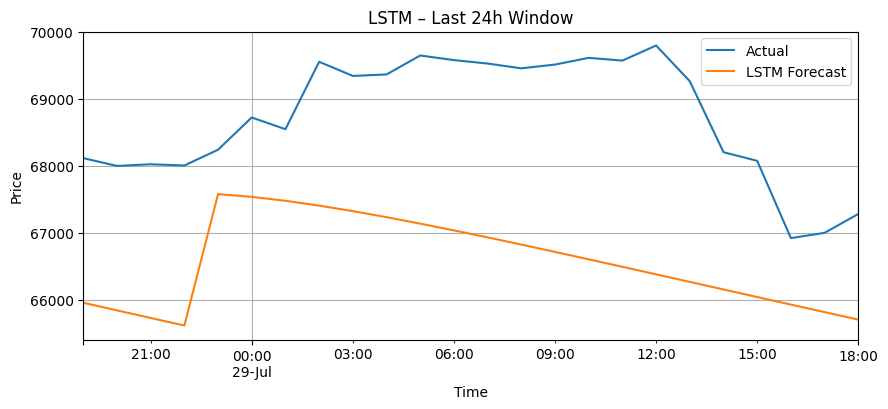

In [ ]:
def lstm_forecast_24(model, history_scaled, scaler, window=48, H=24):
    model.eval()
    seq = history_scaled.copy().astype(np.float32)
    preds_scaled = []
    with torch.no_grad():
        for _ in range(H):
            x = torch.tensor(seq[-window:].reshape(1, window, 1))
            yhat = model(x).cpu().numpy().flatten()[0]
            preds_scaled.append(yhat)
            seq = np.append(seq, yhat)
    preds_scaled = np.array(preds_scaled).reshape(-1,1)
    preds = scaler.inverse_transform(preds_scaled).flatten()
    return preds


preds_lstm_list, actuals_lstm_list = [], []

# Dados escalados de treino + validação
fit_scaled = scaler.transform(y_fit.values.reshape(-1,1)).flatten()

# Faz previsões em blocos de 24h, pulando o i=0 (pois não há histórico de teste ainda)
for i in range(H, len(y_test), H):
    # concatena histórico de treino+val + parte observada do teste até i
    hist_part = y_test.iloc[:i]
    hist_scaled = np.concatenate([
        fit_scaled,
        scaler.transform(hist_part.values.reshape(-1,1)).flatten()
    ])
    preds24 = lstm_forecast_24(model, hist_scaled, scaler, window=window, H=H)
    idx = y_test.index[i:i+H]
    preds_lstm_list.append(pd.Series(preds24[:len(idx)], index=idx))
    actuals_lstm_list.append(y_test.iloc[i:i+H])

preds_lstm = pd.concat(preds_lstm_list)
actuals_lstm = pd.concat(actuals_lstm_list)

print("LSTM RMSE:", rmse(actuals_lstm, preds_lstm))
print("LSTM MAE :", mean_absolute_error(actuals_lstm, preds_lstm))
print("LSTM sMAPE (%):", smape(actuals_lstm, preds_lstm))

# Plotar última janela
plt.figure(figsize=(10,4))
actuals_lstm[-H:].plot(label="Actual")
preds_lstm[-H:].plot(label="LSTM Forecast")
plt.legend(); plt.title("LSTM – Last 24h Window"); plt.xlabel("Time"); plt.ylabel("Price")
plt.show()


## 9) Metrics comparison and discussion

We compare **Naïve**, **AutoARIMA (sktime)**, and **LSTM** on the same rolling 24-hour evaluation
over the test set using **RMSE**, **MAE**, and **sMAPE**.

- **RMSE** is standard and penalizes larger errors more strongly (useful for price scale).  
- **MAE** is scale-dependent and easier to interpret as “average absolute error.”  
- **sMAPE** is scale-free and bounded (0–200%), more robust than MAPE when values get close to zero.


In [ ]:
summary = pd.DataFrame({
    "Model": ["Naive", "AutoARIMA", "LSTM"],
    "RMSE": [
        rmse(actuals, preds_naive),
        rmse(y_test, preds_arima),
        rmse(actuals_lstm, preds_lstm),
    ],
    "MAE": [
        mean_absolute_error(actuals, preds_naive),
        mean_absolute_error(y_test, preds_arima),
        mean_absolute_error(actuals_lstm, preds_lstm),
    ],
    "sMAPE_%": [
        smape(actuals, preds_naive),
        smape(y_test, preds_arima),
        smape(actuals_lstm, preds_lstm),
    ],
}).set_index("Model")

print(summary)


                   RMSE           MAE    sMAPE_%
Model                                           
Naive        862.014295    534.059566   1.228409
AutoARIMA  39629.701234  39462.050335  89.241966
LSTM        1941.355950   1580.153856   2.495929
